#Autoenkoder do kolorowania obrazów czarno-białych

Bartłomiej Kowalewski, 145204 - praca wykonywana jednosobowo \\
Wtorek 15:10

## 1. Import wymaganych bibliotek
W projekcie wykorzystano biblioteki takie, jak:
- numpy,
- matplotlib,
- opencv,
- wiele pakietów z biblioteki tensorflow.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras.layers import MaxPool2D, Conv2D, Conv2DTranspose, UpSampling2D, Input, InputLayer, Dropout, Dense, BatchNormalization, Flatten, LeakyReLU
from tensorflow.keras.losses import categorical_crossentropy, mse
from tensorflow.keras.optimizers import Adadelta, RMSprop, Adam, SGD
from tensorflow.python.keras import backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
import IPython.display
import PIL.Image

## 2. Definicja modeli autoenkoderów

W ramach projektu przygotowano 3 modele autoenkoderów. Każdy z nich składa się z warstw konwolucyjnych.

###2.1 Autoenkoder składający się z warstw konwolucyjnych - wersja 1
Pierwszy z modeli składa się z:
- 2 wartsw konwolucyjnych Conv2D()
- 3 par naprzemiennie po sobie występujących warstw konwolucyjnych Conv2D() i warstw regularyzacji - BatchNormalization()

Opisane warstwy odpowiadają za downsampling. Funkcją aktywacji wymienionych warstw konwolucyjnych jest Relu.

Następna część modelu odpowiada za dekonwolucję. W jej skład wchodzi:
- 5 warstw typu Conv2DTranspose() z funkcją aktywacji Relu,
- warstwa Conv2D() z funkcją aktywacji Sigmoid

In [ ]:
class AutoEncoderConv1(Model):
  def __init__(self):
    super(AutoEncoderConv1, self).__init__(name='auto_encoder_conv1')
    self.layer_input = InputLayer((32, 32, 1,))
    self.layer_1 = Conv2D(128, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_2 = Conv2D(128, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_3 = Conv2D(256, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.batch_3 = BatchNormalization()
    self.layer_4 = Conv2D(512, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.batch_4 = BatchNormalization()
    self.layer_5 = Conv2D(512, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.batch_5 = BatchNormalization()

    self.layer_up_1 = Conv2DTranspose(512, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_up_2 = Conv2DTranspose(512, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_up_3 = Conv2DTranspose(256, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_up_4 = Conv2DTranspose(128, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_up_5 = Conv2DTranspose(128, (3, 3), activation='relu', padding = 'same', strides = 2)
    self.layer_up_6 = Conv2D(3, (3, 3), activation='sigmoid', padding = 'same', strides = 1)

  def call(self, inputs):
    x = self.layer_input(inputs)
    d1 = self.layer_1(x)
    d2 = self.layer_2(d1)
    d3 = self.layer_3(d2)
    d3 = self.batch_3(d3)
    d4 = self.layer_4(d3)
    d4 = self.batch_4(d4)
    d5 = self.layer_5(d4)
    d5 = self.batch_5(d5)

    u1 = self.layer_up_1(d5)
    u2 = self.layer_up_2(u1)
    u3 = self.layer_up_3(u2)
    u4 = self.layer_up_4(u3)
    u5 = self.layer_up_5(u4)

    y = self.layer_up_6(u5)
    return y

###2.2 Autoenkoder składający się z warstw konwolucyjnych - wersja 2
Kolejny model autoenkodera zostal złożony z dwóch modeli: Enkodera i Dekodera. Enkoder składa się z 3 par naprzemiennie występujących po sobie warstw Conv2D() z funkcją aktywacji Relu oraz warstwy regularyzacji BatchNormalization(). Natomiast w przypadku Dekodera zastosowano 3 warstwy Conv2DTranspose() z funkcją aktywacji Relu oraz jedną warstwę Conv2D() z funkcją aktywacji Sigmoid. Ten model autoenkodera jest bardzo zbliżony do modelu z poprzedniego podpunktu, jednak w tym przypadku zastosowano mniej warstw.

In [ ]:
class EncoderConv2(Model):
  def __init__(self):
    super(EncoderConv2, self).__init__(name='encoder_conv2')
    self.layer_1 = Conv2D(filters=64, kernel_size=3, activation='relu', padding = 'same', strides = 2)
    self.batch_1 = BatchNormalization()
    self.layer_2 = Conv2D(filters=128, kernel_size=3, activation='relu', padding = 'same', strides = 2)
    self.batch_2 = BatchNormalization()
    self.layer_3 = Conv2D(filters=256, kernel_size=3, activation='relu', padding = 'same', strides = 2)
    self.batch_3 = BatchNormalization()

  def call(self, x):
    x = self.layer_1(x)
    x = self.batch_1(x)
    x = self.layer_2(x)
    x = self.batch_2(x)
    x = self.layer_3(x)
    x = self.batch_3(x)
    return x

class DecoderConv2(Model):
  def __init__(self):
    super(DecoderConv2, self).__init__(name='decoder_conv2')
    self.layer_1 = Conv2DTranspose(filters=256, kernel_size=3, activation='relu', padding='same', strides=2)
    self.layer_2 = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', padding='same', strides=2)
    self.layer_3 = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same', strides=2)
    self.layer_4 = Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same')

  def call(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    return x


class AutoEncoderConv2(Model):
  def __init__(self):
    super(AutoEncoderConv2, self).__init__(name='autoencoder_conv2')
    self.encoder = EncoderConv2()
    self.decoder = DecoderConv2()

  def call(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

###2.3 Autoenkoder składający się z warstw konwolucyjnych - wersja 3
Ostatni przygotowany model autoenkodera również został złożony z dwóch osobnych modeli. W tym przypadku w skład enkodera wchodzi 8 warstw Conv2D() z funkcją aktywacji Relu. Natomiast dekoder składa się z 2 par naprzemiennie występujących po sobie warstw Conv2D() z funkcją aktywacji Relu oraz warstw UpSampling2D(). Następne 3 warstwy to znów Conv2D() z funkcją aktywacji Relu. Ostatnią warstwą jest UpSampling2D().

In [ ]:
class EncoderConv3(Model):
  def __init__(self):
    super(EncoderConv3, self).__init__(name='encoder_conv3')
    self.layer_input = InputLayer((32, 32, 1,))
    self.layer_1 = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))
    self.layer_2 = Conv2D(128, (3, 3), activation='relu', padding='same')
    self.layer_3 = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))
    self.layer_4 = Conv2D(64, (3, 3), activation='relu', padding='same')
    self.layer_5 = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))
    self.layer_6 = Conv2D(32, (3, 3), activation='relu', padding='same')
    self.layer_7 = Conv2D(32, (3, 3), activation='relu', padding='same')
    self.layer_8 = Conv2D(16, (3, 3), activation='relu', padding='same')

  def call(self, inputs):
    x = self.layer_input(inputs)
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    x = self.layer_5(x)
    x = self.layer_6(x)
    x = self.layer_7(x)
    x = self.layer_8(x)
    return x

class DecoderConv3(Model):
  def __init__(self):
    super(DecoderConv3, self).__init__(name='decoder_conv3')
    self.layer_1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')
    self.layer_2 = UpSampling2D((2, 2))
    self.layer_3 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')
    self.layer_4 = UpSampling2D((2, 2))
    self.layer_5 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')
    self.layer_6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')
    self.layer_7 = Conv2D(3, (3, 3), activation = 'tanh', padding = 'same')
    self.layer_8 = UpSampling2D((2, 2))

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    x = self.layer_5(x)
    x = self.layer_6(x)
    x = self.layer_7(x)
    x = self.layer_8(x)
    return x


class AutoEncoderConv3(Model):
  def __init__(self):
    super(AutoEncoderConv3, self).__init__(name='autoencoder_conv3')
    self.encoder = EncoderConv3()
    self.decoder = DecoderConv3()

  def call(self, inputs):
    x = self.encoder(inputs)
    x = self.decoder(x)
    return x

## 3. Wczytanie i przygotowanie danych
Do zastosowania w trakcie pracy nad projektem został wybrany zbiór danych cifar100 ze zbiorów dostępnych w bibliotece tensorflow.datasets. W zbiorze znajdują się zdjęcia o rozmiarze 32x32, które zostały podzielone na zbiór treningowy w ilości 50000 oraz zbiór testowy w ilości 10000. Zdjęcia po wczytaniu zostają znormalizowane do przedziału 0-1. Zdjęcia, które zostają podane na wejście do modelu autoenkodera konwertowane są z kolorowych (3 kanały) na obrazy w skali szarości (1 kanał).

In [ ]:
(y_train, _), (y_test, _) = cifar100.load_data()

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_train /= 255
y_test /= 255

x_train = []
x_test = []

for i in y_train:
  x_train.append(cv.cvtColor(i, cv.COLOR_RGB2GRAY))

for i in y_test:
  x_test.append(cv.cvtColor(i, cv.COLOR_RGB2GRAY))

x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)

169001437/169001437 [==============================] - 13s 0us/step


Drugim zbiorem danych, na których miały zostać przetestowane przygotowane modele autoenkoderów jest zbiór "stl10", który również pochodzi z gotowych zbiorów danych z biblioteki tensorflow.datasets. Jednak, m.in. z powodu ograniczeń platformy  Google Colab, na której przygotowywany był projekt tj.: limitu czasu wykorzystania układów GPU, ograniczenia dostępnej pamięci RAM, a także dużego rozmiaru wybranego zbioru ostatecznie zdecydowano się wybrać zbiór cifar100.

In [ ]:
# dataset_train, dataset_test = tfds.load('stl10', split=['test', 'train'])

# y_train = []
# y_test = []

# for i in dataset_train:
#   y_train.append(i["image"])

# for i in dataset_test:
#   y_test.append(i["image"])

# y_train = np.array(y_train)
# y_test = np.array(y_test)

# print('y train shape', y_train.shape)

# print('y test  shape', y_test.shape)

# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')
# y_train /= 255
# y_test /= 255

# x_train = []
# x_test = []

# for i in y_train:
#   x_train.append(cv.cvtColor(i, cv.COLOR_RGB2GRAY))

# for i in y_test:
#   x_test.append(cv.cvtColor(i, cv.COLOR_RGB2GRAY))

# x_train = np.expand_dims(x_train, axis = 3)
# x_test = np.expand_dims(x_test, axis = 3)

## 4. Uczenie modeli
W tej części przygotowane i opisane wcześniej modele uczenia maszynowego zostaną poddane procesowi uczenia. Wszystkie modele zostały uczone podczas 100 epok z wykorzystaniem różnych optymalizatorów. Batch size wynosił 128. Jako funkcje straty wykorzystano średni błąd kwadratowy (mse). W poszczególnych wariantach przetestowano wykorzystanie różnych optymalizatorów.

### 4.1 Model konwolucyjny - wersja 1

Model nr 1 - optymalizator Adam()

Wyniki tego wariantu:
- loss: **0.049**
- accuracy: **0.7040**
- val_loss: **0.0136**
- val_accuracy: **0.4986**

In [ ]:
model1 = AutoEncoderConv1()
model1.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])
model1.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 31s 75ms/step - loss: 0.0266 - accuracy: 0.5014 - val_loss: 0.0382 - val_accuracy: 0.5307
Epoch 2/100
391/391 [==============================] - 27s 70ms/step - loss: 0.0187 - accuracy: 0.5109 - val_loss: 0.0272 - val_accuracy: 0.5380
Epoch 3/100
391/391 [==============================] - 27s 69ms/step - loss: 0.0172 - accuracy: 0.5189 - val_loss: 0.0357 - val_accuracy: 0.4638
Epoch 4/100
391/391 [==============================] - 27s 70ms/step - loss: 0.0162 - accuracy: 0.5184 - val_loss: 0.0232 - val_accuracy: 0.5295
Epoch 5/100
391/391 [==============================] - 27s 70ms/step - loss: 0.0154 - accuracy: 0.5204 - val_loss: 0.0193 - val_accuracy: 0.5401
Epoch 6/100
391/391 [==============================] - 27s 69ms/step - loss: 0.0150 - accuracy: 0.5242 - val_loss: 0.0165 - val_accuracy: 0.4820
Epoch 7/100
391/391 [==============================] - 27s 69ms/step - loss: 0.0147 - accuracy: 0.5253 - val_loss: 0.0190 - val_ac

### 4.2 Model konwolucyjny - wersja 2

Model nr 2 - optymalizator Adam()

Wyniki tego wariantu:
- loss: **0.0033**
- accuracy: **0.6092**
- val_loss: **0.0111**
- val_accuracy: **0.5050**

In [ ]:
model2 = AutoEncoderConv2()
model2.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics=['accuracy'])
model2.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 14s 32ms/step - loss: 0.0139 - accuracy: 0.4891 - val_loss: 0.0426 - val_accuracy: 0.3800
Epoch 2/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0102 - accuracy: 0.5079 - val_loss: 0.0104 - val_accuracy: 0.5314
Epoch 3/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0095 - accuracy: 0.5128 - val_loss: 0.0111 - val_accuracy: 0.5159
Epoch 4/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0093 - accuracy: 0.5154 - val_loss: 0.0094 - val_accuracy: 0.4908
Epoch 5/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0091 - accuracy: 0.5170 - val_loss: 0.0097 - val_accuracy: 0.4899
Epoch 6/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0090 - accuracy: 0.5183 - val_loss: 0.0101 - val_accuracy: 0.5363
Epoch 7/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0088 - accuracy: 0.5205 - val_loss: 0.0092 - val_ac

Model nr 2 - optymalizator RMSprop()

Wyniki tego wariantu:
- loss: **0.0038**
- accuracy: **0.5994**
- val_loss: **0.0106**
- val_accuracy: **0.5028**

In [ ]:
model2b = AutoEncoderConv2()
model2b.compile(optimizer=RMSprop(), loss='mse', metrics=['accuracy'])
model2b.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 13s 31ms/step - loss: 0.0149 - accuracy: 0.4882 - val_loss: 0.0353 - val_accuracy: 0.3084
Epoch 2/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0107 - accuracy: 0.5035 - val_loss: 0.0103 - val_accuracy: 0.5260
Epoch 3/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0100 - accuracy: 0.5090 - val_loss: 0.0094 - val_accuracy: 0.5332
Epoch 4/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0096 - accuracy: 0.5137 - val_loss: 0.0104 - val_accuracy: 0.5376
Epoch 5/100
391/391 [==============================] - 12s 32ms/step - loss: 0.0093 - accuracy: 0.5175 - val_loss: 0.0096 - val_accuracy: 0.5284
Epoch 6/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0091 - accuracy: 0.5215 - val_loss: 0.0089 - val_accuracy: 0.5070
Epoch 7/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0090 - accuracy: 0.5248 - val_loss: 0.0094 - val_ac

Model nr 2 - optymalizator Adadelta()

Wyniki tego wariantu:
- loss: **0.0566**
- accuracy: **0.5010**
- val_loss: **0.0569**
- val_accuracy: **0.5047**

In [ ]:
model2c = AutoEncoderConv2()
model2c.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy'])
model2c.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 13s 31ms/step - loss: 0.0724 - accuracy: 0.3255 - val_loss: 0.0728 - val_accuracy: 0.3230
Epoch 2/100
391/391 [==============================] - 12s 30ms/step - loss: 0.0723 - accuracy: 0.3301 - val_loss: 0.0727 - val_accuracy: 0.3326
Epoch 3/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0722 - accuracy: 0.3348 - val_loss: 0.0727 - val_accuracy: 0.3369
Epoch 4/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0722 - accuracy: 0.3394 - val_loss: 0.0726 - val_accuracy: 0.3417
Epoch 5/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0721 - accuracy: 0.3441 - val_loss: 0.0725 - val_accuracy: 0.3464
Epoch 6/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0720 - accuracy: 0.3487 - val_loss: 0.0725 - val_accuracy: 0.3510
Epoch 7/100
391/391 [==============================] - 12s 31ms/step - loss: 0.0720 - accuracy: 0.3533 - val_loss: 0.0724 - val_ac

### 4.3 Model konwolucyjny - wersja 3

Model nr 3 - optymalizator Adam()

Wyniki tego wariantu:
- loss: **0.0088**
- accuracy: **0.6054**
- val_loss: **0.0143**
- val_accuracy: **0.5339**

In [ ]:
model3 = AutoEncoderConv3()
model3.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics=['accuracy'])
model3.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 12s 27ms/step - loss: 0.0315 - accuracy: 0.4950 - val_loss: 0.0214 - val_accuracy: 0.5271
Epoch 2/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0199 - accuracy: 0.4965 - val_loss: 0.0192 - val_accuracy: 0.4922
Epoch 3/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0184 - accuracy: 0.4973 - val_loss: 0.0184 - val_accuracy: 0.4962
Epoch 4/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0177 - accuracy: 0.4974 - val_loss: 0.0173 - val_accuracy: 0.4941
Epoch 5/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0171 - accuracy: 0.5040 - val_loss: 0.0180 - val_accuracy: 0.5388
Epoch 6/100
391/391 [==============================] - 9s 24ms/step - loss: 0.0167 - accuracy: 0.5068 - val_loss: 0.0171 - val_accuracy: 0.5446
Epoch 7/100
391/391 [==============================] - 9s 24ms/step - loss: 0.0164 - accuracy: 0.5105 - val_loss: 0.0168 - val_accu

Model nr 3 - optymalizator RMSprop()

Wyniki tego wariantu:
- loss: **0.0119**
- accuracy: **0.5861**
- val_loss: **0.0165**
- val_accuracy: **0.5031**

In [ ]:
model3a = AutoEncoderConv3()
model3a.compile(optimizer=RMSprop(), loss='mse', metrics=['accuracy'])
model3a.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 11s 26ms/step - loss: 0.0511 - accuracy: 0.5158 - val_loss: 0.0284 - val_accuracy: 0.5305
Epoch 2/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0280 - accuracy: 0.5061 - val_loss: 0.0237 - val_accuracy: 0.4985
Epoch 3/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0245 - accuracy: 0.5065 - val_loss: 0.0230 - val_accuracy: 0.5013
Epoch 4/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0226 - accuracy: 0.5076 - val_loss: 0.0234 - val_accuracy: 0.4769
Epoch 5/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0214 - accuracy: 0.5073 - val_loss: 0.0229 - val_accuracy: 0.5065
Epoch 6/100
391/391 [==============================] - 10s 24ms/step - loss: 0.0207 - accuracy: 0.5091 - val_loss: 0.0202 - val_accuracy: 0.5183
Epoch 7/100
391/391 [==============================] - 10s 24ms/step - loss: 0.0201 - accuracy: 0.5092 - val_loss: 0.0206 - val_ac

Model nr 3 - optymalizator Adadelta()

Wyniki tego wariantu:
- loss: **0.0408**
- accuracy: **0.5182**
- val_loss: **0.0411**
- val_accuracy: **0.5222**

In [ ]:
model3b = AutoEncoderConv3()
model3b.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy'])
model3b.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 11s 26ms/step - loss: 0.2968 - accuracy: 0.2498 - val_loss: 0.2927 - val_accuracy: 0.2430
Epoch 2/100
391/391 [==============================] - 10s 25ms/step - loss: 0.2834 - accuracy: 0.2430 - val_loss: 0.2762 - val_accuracy: 0.2401
Epoch 3/100
391/391 [==============================] - 10s 25ms/step - loss: 0.2626 - accuracy: 0.2445 - val_loss: 0.2498 - val_accuracy: 0.2439
Epoch 4/100
391/391 [==============================] - 10s 25ms/step - loss: 0.2277 - accuracy: 0.2449 - val_loss: 0.2045 - val_accuracy: 0.2410
Epoch 5/100
391/391 [==============================] - 10s 25ms/step - loss: 0.1712 - accuracy: 0.2436 - val_loss: 0.1385 - val_accuracy: 0.2410
Epoch 6/100
391/391 [==============================] - 10s 25ms/step - loss: 0.1114 - accuracy: 0.2553 - val_loss: 0.0943 - val_accuracy: 0.2868
Epoch 7/100
391/391 [==============================] - 10s 25ms/step - loss: 0.0882 - accuracy: 0.4131 - val_loss: 0.0864 - val_ac

### 4.4 Tabela zbiorcza uzyskanych wyników po 100 epokach dla każdego modelu

| **Model \ parametr**   | **Loss** | **Accuracy** | **Validation Loss** | **Validation Accuracy** |
|------------------------|----------|--------------|---------------------|-------------------------|
| **Model 1 - Adam**     | 0.0049    | 0.7040       | 0.0136              | 0.4986                  |
| **Model 2 - Adam**     | 0.0033   | 0.6092       | 0.0111              | 0.5050                  |
| **Model 2 - RMSprop**  | 0.0038   | 0.5994       | 0.0106              | 0.5028                  |
| **Model 2 - Adadelta** | 0.0566   | 0.5010       | 0.0569              | 0.5047                  |
| **Model 3 - Adam**     | 0.0088   | 0.6054       | 0.0143              | 0.5339                  |
| **Model 3 - RMSprop**  | 0.0119   | 0.5861       | 0.0165              | 0.5031                  |
| **Model 3 - Adadelta** | 0.0408   | 0.5182       | 0.0411              | 0.5222                  |

## 5. Przedstawienie wyników uczenia

In [ ]:
def plot_result(x, y, Y):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
  ax1.imshow(x.reshape(x.shape[0], x.shape[1]), cmap='gray')
  ax2.imshow(Y)
  ax3.imshow(y)
  ax1.set_title('input')
  ax2.set_title('output')
  ax3.set_title('expected')
  
def plot_test_result(index, model_test):
  plot_result(x_test[index], y_test[index], model_test[index])

4/4 [==============================] - 0s 94ms/step


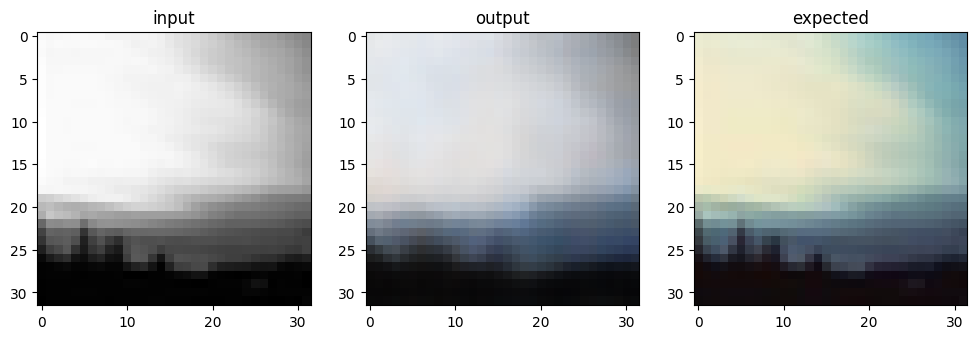

In [ ]:
model1_test = model1.predict(x_test[:100,:,:,:])
plot_test_result(8, model1_test)

4/4 [==============================] - 0s 7ms/step


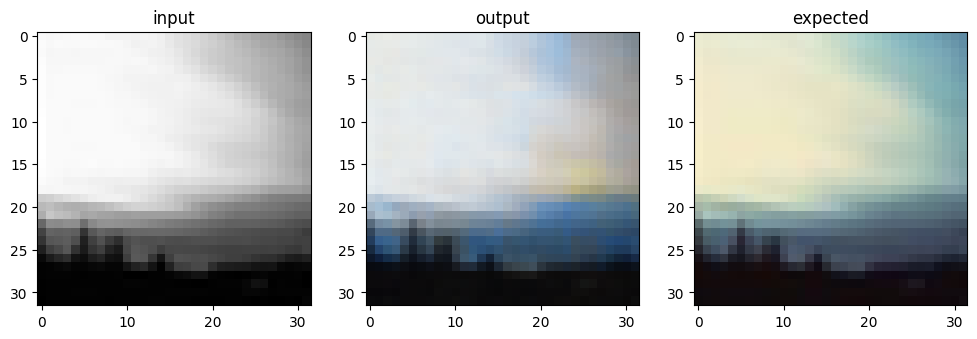

In [ ]:
model2_test = model2.predict(x_test[:100,:,:,:])
plot_test_result(8, model2_test)

4/4 [==============================] - 0s 4ms/step


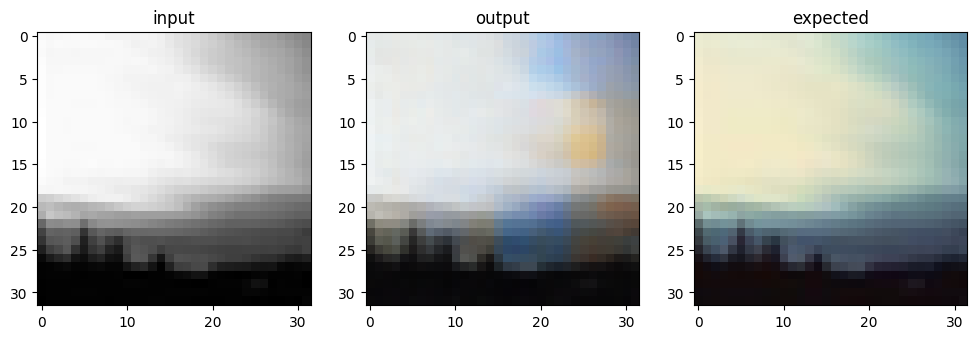

In [ ]:
model2b_test = model2b.predict(x_test[:100,:,:,:])
plot_test_result(8, model2b_test)

4/4 [==============================] - 0s 4ms/step


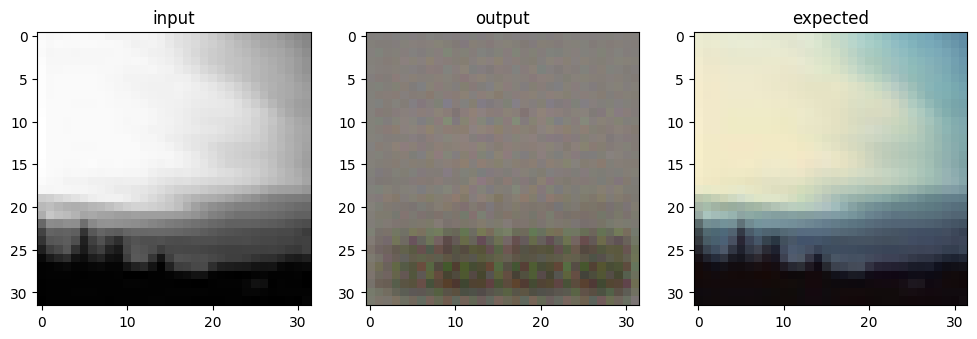

In [ ]:
model2c_test = model2c.predict(x_test[:100,:,:,:])
plot_test_result(8, model2c_test)

4/4 [==============================] - 0s 4ms/step


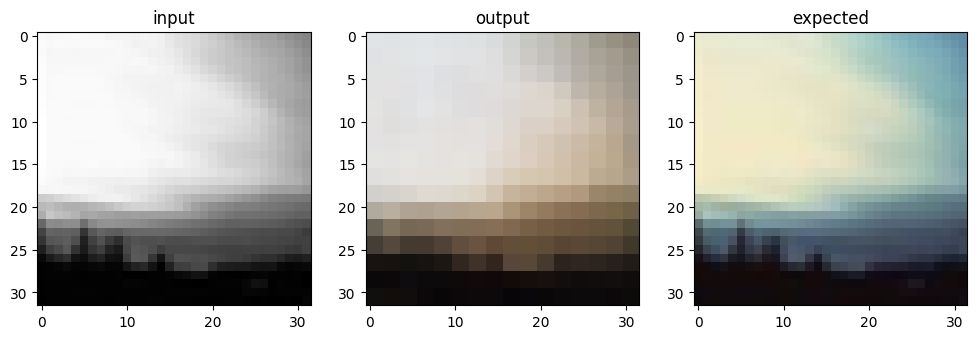

In [ ]:
model3_test = model3.predict(x_test[:100,:,:,:])
plot_test_result(8, model3_test)

4/4 [==============================] - 0s 4ms/step


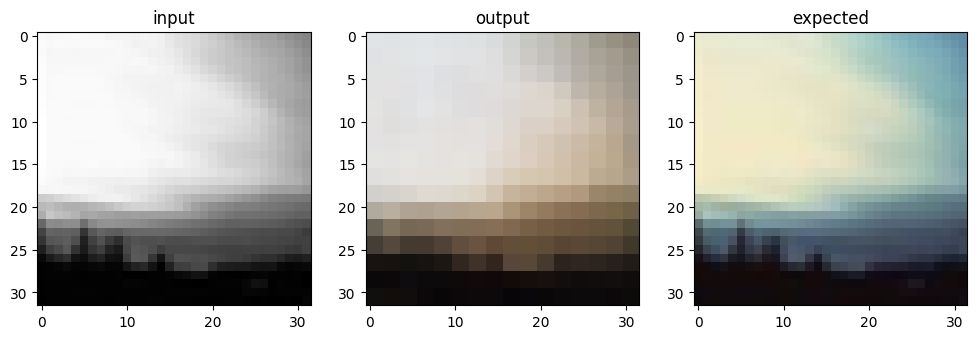

In [ ]:
model3a_test = model3.predict(x_test[:100,:,:,:])
plot_test_result(8, model3a_test)

4/4 [==============================] - 0s 5ms/step


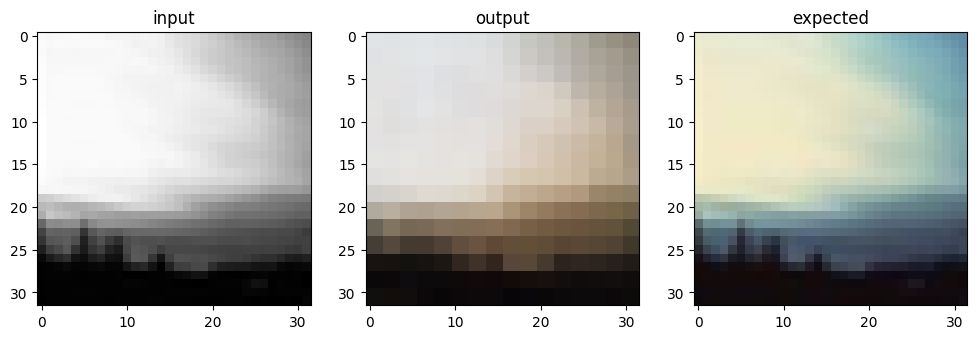

In [ ]:
model3b_test = model3.predict(x_test[:100,:,:,:])
plot_test_result(8, model3b_test)

## 6. Uczenie modeli z innym batch size
Przygotowane trzy modele zostały również poddane procesowi uczenia podczas 100 epok przy wartości parametru batch_size równym 64 oraz optymalizatorze Adam. Jako funkcję straty wykorzystano "mse". Otrzymane w tym przypadku wyniki nie odbiegają zbytnio od tych otrzymanych przy zastosowaniu batch_size o wartości 128.

In [ ]:
model1_64 = AutoEncoderConv1()
model1_64.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])
model1_history = model1_64.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
782/782 [==============================] - 38s 48ms/step - loss: 0.0254 - accuracy: 0.5111 - val_loss: 0.0322 - val_accuracy: 0.5277
Epoch 2/100
782/782 [==============================] - 37s 47ms/step - loss: 0.0189 - accuracy: 0.5129 - val_loss: 0.0200 - val_accuracy: 0.5122
Epoch 3/100
782/782 [==============================] - 37s 48ms/step - loss: 0.0177 - accuracy: 0.5165 - val_loss: 0.0198 - val_accuracy: 0.4983
Epoch 4/100
782/782 [==============================] - 37s 47ms/step - loss: 0.0167 - accuracy: 0.5188 - val_loss: 0.0178 - val_accuracy: 0.5216
Epoch 5/100
782/782 [==============================] - 37s 47ms/step - loss: 0.0160 - accuracy: 0.5211 - val_loss: 0.0191 - val_accuracy: 0.5099
Epoch 6/100
782/782 [==============================] - 37s 47ms/step - loss: 0.0155 - accuracy: 0.5223 - val_loss: 0.0175 - val_accuracy: 0.5488
Epoch 7/100
782/782 [==============================] - 37s 47ms/step - loss: 0.0152 - accuracy: 0.5264 - val_loss: 0.0176 - val_ac

In [ ]:
model2_64 = AutoEncoderConv2()
model2_64.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])
model2_history = model2_64.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
782/782 [==============================] - 16s 19ms/step - loss: 0.0130 - accuracy: 0.4919 - val_loss: 0.0102 - val_accuracy: 0.4947
Epoch 2/100
782/782 [==============================] - 14s 18ms/step - loss: 0.0101 - accuracy: 0.5065 - val_loss: 0.0102 - val_accuracy: 0.5059
Epoch 3/100
782/782 [==============================] - 15s 19ms/step - loss: 0.0096 - accuracy: 0.5123 - val_loss: 0.0094 - val_accuracy: 0.5557
Epoch 4/100
782/782 [==============================] - 15s 19ms/step - loss: 0.0094 - accuracy: 0.5159 - val_loss: 0.0092 - val_accuracy: 0.5027
Epoch 5/100
782/782 [==============================] - 15s 19ms/step - loss: 0.0091 - accuracy: 0.5184 - val_loss: 0.0090 - val_accuracy: 0.5075
Epoch 6/100
782/782 [==============================] - 15s 19ms/step - loss: 0.0089 - accuracy: 0.5207 - val_loss: 0.0127 - val_accuracy: 0.5379
Epoch 7/100
782/782 [==============================] - 15s 19ms/step - loss: 0.0088 - accuracy: 0.5232 - val_loss: 0.0090 - val_ac

In [ ]:
model3_64 = AutoEncoderConv3()
model3_64.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])
model3_history = model3_64.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
782/782 [==============================] - 13s 15ms/step - loss: 0.0256 - accuracy: 0.4935 - val_loss: 0.0192 - val_accuracy: 0.5241
Epoch 2/100
782/782 [==============================] - 11s 14ms/step - loss: 0.0181 - accuracy: 0.4948 - val_loss: 0.0175 - val_accuracy: 0.4934
Epoch 3/100
782/782 [==============================] - 11s 14ms/step - loss: 0.0171 - accuracy: 0.4966 - val_loss: 0.0171 - val_accuracy: 0.5348
Epoch 4/100
782/782 [==============================] - 12s 15ms/step - loss: 0.0165 - accuracy: 0.5007 - val_loss: 0.0170 - val_accuracy: 0.4983
Epoch 5/100
782/782 [==============================] - 12s 15ms/step - loss: 0.0160 - accuracy: 0.5045 - val_loss: 0.0158 - val_accuracy: 0.5236
Epoch 6/100
782/782 [==============================] - 12s 15ms/step - loss: 0.0156 - accuracy: 0.5092 - val_loss: 0.0152 - val_accuracy: 0.5112
Epoch 7/100
782/782 [==============================] - 11s 14ms/step - loss: 0.0152 - accuracy: 0.5129 - val_loss: 0.0153 - val_ac

4/4 [==============================] - 0s 9ms/step


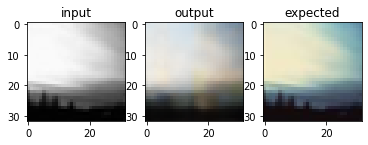

In [ ]:
model1_64_test = model1_64.predict(x_test[:100,:,:,:])
plot_test_result(8, model1_64_test)

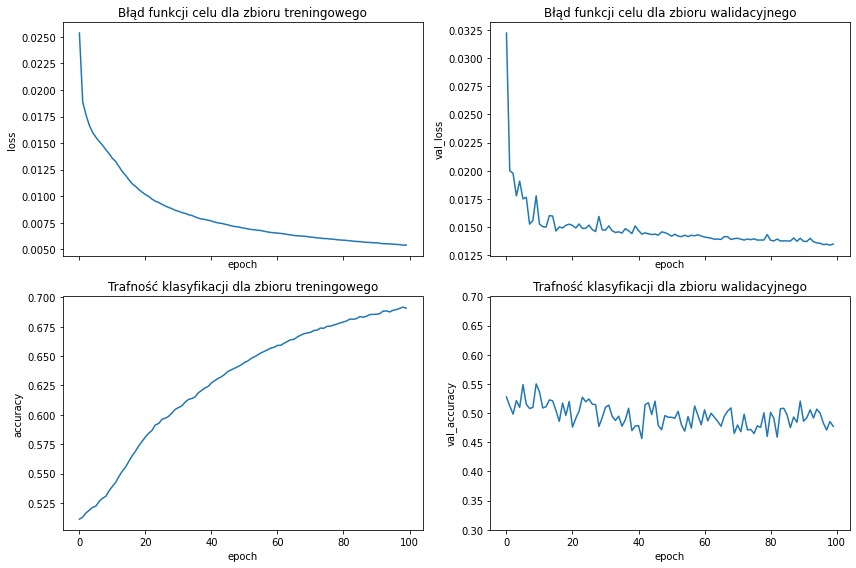

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(model1_history.history['loss'], label='Model 1')
axs[0, 0].set_title("Błąd funkcji celu dla zbioru treningowego")
axs[0, 0].set_ylabel('loss')
axs[0, 0].set_xlabel('epoch')

axs[0, 1].plot(model1_history.history['val_loss'], label='Model 1')
axs[0, 1].set_title("Błąd funkcji celu dla zbioru walidacyjnego")
axs[0, 1].set_ylabel('val_loss')
axs[0, 1].set_xlabel('epoch')

axs[1, 0].plot(model1_history.history['accuracy'], label='Model 1')
axs[1, 0].set_title("Trafność klasyfikacji dla zbioru treningowego")
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].set_xlabel('epoch')

axs[1, 1].plot(model1_history.history['val_accuracy'], label='Model 1')
axs[1, 1].set_title("Trafność klasyfikacji dla zbioru walidacyjnego")
axs[1, 1].set_ylim(0.3, 0.7)
axs[1, 1].set_ylabel('val_accuracy')
axs[1, 1].set_xlabel('epoch')

fig.tight_layout()

4/4 [==============================] - 0s 21ms/step


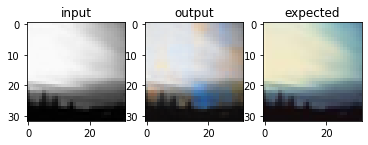

In [ ]:
model2_64_test = model2_64.predict(x_test[:100,:,:,:])
plot_test_result(8, model2_64_test)

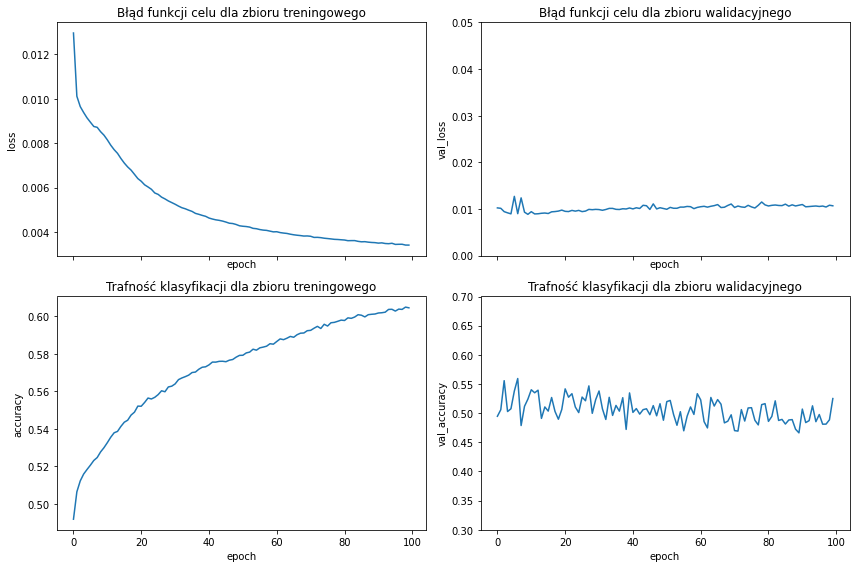

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(model2_history.history['loss'], label='Model 2')
axs[0, 0].set_title("Błąd funkcji celu dla zbioru treningowego")
axs[0, 0].set_ylabel('loss')
axs[0, 0].set_xlabel('epoch')

axs[0, 1].plot(model2_history.history['val_loss'], label='Model 2')
axs[0, 1].set_title("Błąd funkcji celu dla zbioru walidacyjnego")
axs[0, 1].set_ylim(0.0, 0.05)
axs[0, 1].set_ylabel('val_loss')
axs[0, 1].set_xlabel('epoch')

axs[1, 0].plot(model2_history.history['accuracy'], label='Model 2')
axs[1, 0].set_title("Trafność klasyfikacji dla zbioru treningowego")
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].set_xlabel('epoch')

axs[1, 1].plot(model2_history.history['val_accuracy'], label='Model 2')
axs[1, 1].set_title("Trafność klasyfikacji dla zbioru walidacyjnego")
axs[1, 1].set_ylim(0.3, 0.7)
axs[1, 1].set_ylabel('val_accuracy')
axs[1, 1].set_xlabel('epoch')

fig.tight_layout()

4/4 [==============================] - 1s 54ms/step


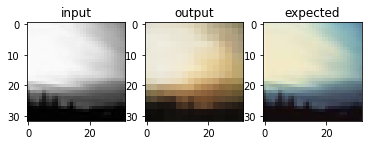

In [ ]:
model3_64_test = model3_64.predict(x_test[:100,:,:,:])
plot_test_result(8, model3_64_test)

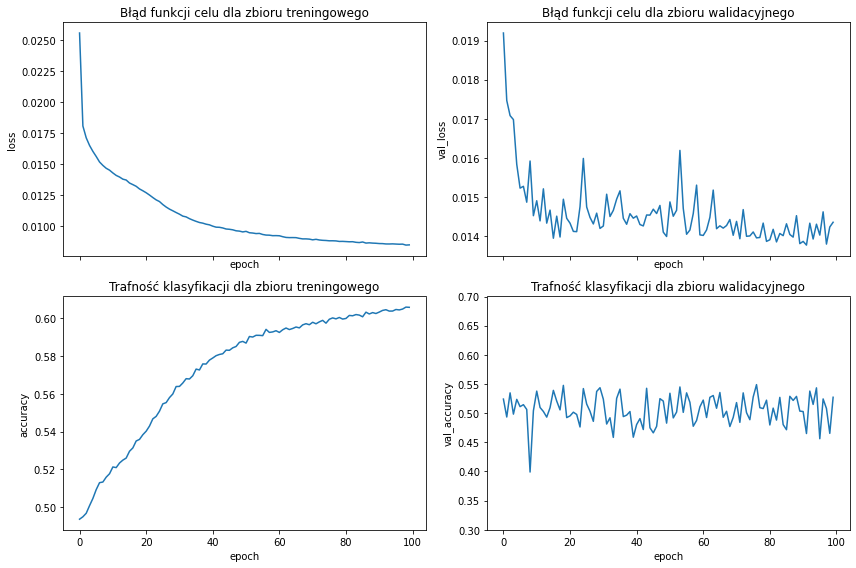

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(model3_history.history['loss'], label='Model 3')
axs[0, 0].set_title("Błąd funkcji celu dla zbioru treningowego")
axs[0, 0].set_ylabel('loss')
axs[0, 0].set_xlabel('epoch')

axs[0, 1].plot(model3_history.history['val_loss'], label='Model 3')
axs[0, 1].set_title("Błąd funkcji celu dla zbioru walidacyjnego")
axs[0, 1].set_ylabel('val_loss')
axs[0, 1].set_xlabel('epoch')

axs[1, 0].plot(model3_history.history['accuracy'], label='Model 3')
axs[1, 0].set_title("Trafność klasyfikacji dla zbioru treningowego")
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].set_xlabel('epoch')

axs[1, 1].plot(model3_history.history['val_accuracy'], label='Model 3')
axs[1, 1].set_title("Trafność klasyfikacji dla zbioru walidacyjnego")
axs[1, 1].set_ylim(0.3, 0.7)
axs[1, 1].set_ylabel('val_accuracy')
axs[1, 1].set_xlabel('epoch')

fig.tight_layout()

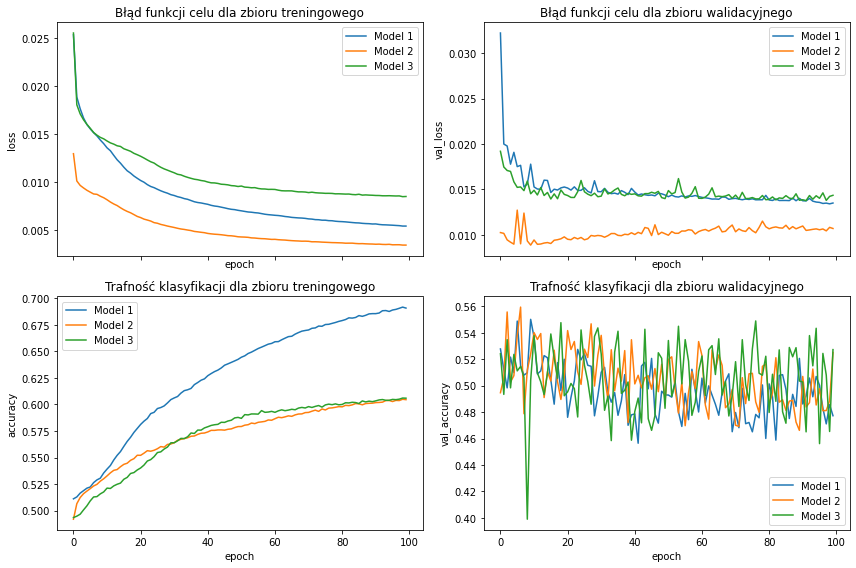

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(model1_history.history['loss'], label='Model 1')
axs[0, 0].plot(model2_history.history['loss'], label='Model 2')
axs[0, 0].plot(model3_history.history['loss'], label='Model 3')
axs[0, 0].set_title("Błąd funkcji celu dla zbioru treningowego")
axs[0, 0].set_ylabel('loss')
axs[0, 0].set_xlabel('epoch')
axs[0, 0].legend(['Model 1', 'Model 2', 'Model 3'])

axs[0, 1].plot(model1_history.history['val_loss'], label='Model 1')
axs[0, 1].plot(model2_history.history['val_loss'], label='Model 2')
axs[0, 1].plot(model3_history.history['val_loss'], label='Model 3')
axs[0, 1].set_title("Błąd funkcji celu dla zbioru walidacyjnego")
axs[0, 1].set_ylabel('val_loss')
axs[0, 1].set_xlabel('epoch')
axs[0, 1].legend(['Model 1', 'Model 2', 'Model 3'])

axs[1, 0].plot(model1_history.history['accuracy'], label='Model 1')
axs[1, 0].plot(model2_history.history['accuracy'], label='Model 2')
axs[1, 0].plot(model3_history.history['accuracy'], label='Model 3')
axs[1, 0].set_title("Trafność klasyfikacji dla zbioru treningowego")
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].set_xlabel('epoch')
axs[1, 0].legend(['Model 1', 'Model 2', 'Model 3'])

axs[1, 1].plot(model1_history.history['val_accuracy'], label='Model 1')
axs[1, 1].plot(model2_history.history['val_accuracy'], label='Model 2')
axs[1, 1].plot(model3_history.history['val_accuracy'], label='Model 3')
#axs[1, 1].set_ylim(0.4, 0.6)
axs[1, 1].set_title("Trafność klasyfikacji dla zbioru walidacyjnego")
axs[1, 1].set_ylabel('val_accuracy')
axs[1, 1].set_xlabel('epoch')
axs[1, 1].legend(['Model 1', 'Model 2', 'Model 3'])

fig.tight_layout()

## 7. Wnioski
Na podstawie przedstawionych w rozdziale 5. wyników uczenia poszczególnych modeli, można stwierdzić, że subiektywnie najlepszym modelem okazał się być model nr 2, wykorzystujący w swojej strukturze warstwę regularyzacji BatchNormalization(). Był on najbliżej odwzorowania kolorów takich, jak na oryginalnym obrazie. Warty odnotowania jest również model nr 1, którego wielkość była największa spośród wszystkich przygotowanych modeli. Wizualnie najsłabiej wypadł model nr 3, który patrząc na porównanie wygenerowanych obrazów oraz tych oryginalnych, najmniej oddaje faktyczne kolory. 